# 2_CDA_Superstore — Churn Valioso basado en K-Means

Este notebook forma parte del proyecto de **Segmentación y Predicción de Churn**.
Aquí realizamos el **CDA (Contrastes de Datos Aplicados)** para validar la definición
de **Churn Valioso** y decidir qué variables tienen sentido para el modelo supervisado.

En el EDA ya se generó el archivo `superstore_procesado.csv` con:

- variables de comportamiento y valor (Recency, MntTotal, TotalPurchases, etc.),
- variables demográficas (Income, Kidhome, Teenhome, Education, Marital_Status),
- CLV exploratorio (`CLV_log`).

En este notebook:

- Definimos el **Churn Valioso basado en K-Means**.
- Aplicamos pruebas estadísticas numéricas y categóricas.
- Comparamos distintas definiciones de churn.
- Extraemos conclusiones y preseleccionamos variables para el modelo.

## 1. Imports y carga del dataset procesado

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, chi2_contingency

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

df = pd.read_csv("../data/superstore_procesado.csv")
print("Shape del dataset procesado:", df.shape)
df.head()

Shape del dataset procesado: (2240, 17)


,Id,Dt_Customer,Recency,CustomerTenure,MntTotal,TotalPurchases,Perc_WebPurchases,Perc_CatalogPurchases,Perc_StorePurchases,Income,Kidhome,Teenhome,Education,Marital_Status,NumWebVisitsMonth,CLV_simple,CLV_log
0,1826,2014-06-16,0,173,1190,15,0.266667,0.266667,0.400000,84835.0,0,0,Graduation,Divorced,1,17850,19.636994
1,1,2014-06-15,0,174,577,18,0.388889,0.166667,0.388889,57091.0,0,0,Graduation,Single,5,10386,18.725377
2,10476,2014-05-13,0,207,251,11,0.272727,0.181818,0.454545,67267.0,0,1,Graduation,Married,2,2761,13.740115
3,1386,2014-11-05,0,31,11,4,0.250000,0.000000,0.500000,32474.0,1,1,Graduation,Together,7,44,3.999303
4,5371,2014-08-04,0,124,91,8,0.375000,0.125000,0.250000,21474.0,1,0,Graduation,Single,7,728,9.935385


## 2. Definición de Churn Valioso basado en K-Means

En el análisis de Recency con K-Means se identificaron **tres clusters de inactividad** y
el cluster más inactivo presentó una media de aproximadamente **83 días sin comprar**.

Definimos:

- Inactividad: `Recency ≥ 83` (umbral data-driven a partir de K-Means).
- Cliente valioso: `CLV_log ≥ mediana`.

A partir de ahí construimos:

- `Churn_Valioso_KMeans`: inactivo **y** de alto valor.
- `Churn_KMeans`: solo inactivo (sin tener en cuenta valor).

In [2]:
# Umbral de inactividad detectado por K-Means
UMBRAL_RECENCY_KMEANS = 83

# Mediana del CLV_log
mediana_clv = df["CLV_log"].median()

# Churn valioso basado en K-Means
df["Churn_Valioso_KMeans"] = (
    (df["Recency"] >= UMBRAL_RECENCY_KMEANS) &
    (df["CLV_log"] >= mediana_clv)
).astype(int)

# Churn simple basado solo en recency
df["Churn_KMeans"] = (df["Recency"] >= UMBRAL_RECENCY_KMEANS).astype(int)

df[["Recency", "CLV_log", "Churn_Valioso_KMeans", "Churn_KMeans"]].head()

,Recency,CLV_log,Churn_Valioso_KMeans,Churn_KMeans
0,0,19.636994,0,0
1,0,18.725377,0,0
2,0,13.740115,0,0
3,0,3.999303,0,0
4,0,9.935385,0,0


### 2.1. Tasas de churn

In [3]:
tasa_churn = df[["Churn_Valioso_KMeans", "Churn_KMeans"]].mean().to_frame("tasa")
tasa_churn

,tasa
Churn_Valioso_KMeans,0.081250
Churn_KMeans,0.165179


## 3. CDA numérico — Mann–Whitney U

Analizamos si las variables numéricas muestran diferencias significativas entre
clientes con **Churn_Valioso_KMeans = 1** y **0**.

Usamos el test **Mann–Whitney U** porque:

- las distribuciones no son normales,
- hay sesgos y outliers,
- es más robusto que un t-test clásico.

También calculamos el **tamaño de efecto (rank biserial)**.

In [4]:
vars_num = [
    "Recency",
    "CustomerTenure",
    "MntTotal",
    "TotalPurchases",
    "Income",
    "NumWebVisitsMonth",
    "Perc_WebPurchases",
    "Perc_CatalogPurchases",
    "Perc_StorePurchases",
    "CLV_log"
]

resultados = []

for var in vars_num:
    if var not in df.columns:
        continue

    g0 = df.loc[df["Churn_Valioso_KMeans"] == 0, var].dropna()
    g1 = df.loc[df["Churn_Valioso_KMeans"] == 1, var].dropna()

    if len(g0) == 0 or len(g1) == 0:
        continue

    u_stat, p_value = mannwhitneyu(g0, g1)
    r_rb = 1 - (2 * u_stat) / (len(g0) * len(g1))

    resultados.append({
        "Variable": var,
        "U_stat": u_stat,
        "p_value": p_value,
        "rank_biserial": r_rb,
        "n_no_churn": len(g0),
        "n_churn": len(g1)
    })

res_num = pd.DataFrame(resultados).sort_values("p_value")
res_num

,Variable,U_stat,p_value,rank_biserial,n_no_churn,n_churn
0,Recency,17249.5,6.853224e-92,0.907894,2058,182
2,MntTotal,82495.5,5.212847e-36,0.559502,2058,182
9,CLV_log,82530.5,5.497791e-36,0.559316,2058,182
3,TotalPurchases,85847.0,6.503066e-34,0.541607,2058,182
4,Income,89248.5,8.445766e-30,0.510461,2037,179
7,Perc_CatalogPurchases,103352.5,4.186671e-24,0.448133,2058,182
5,NumWebVisitsMonth,245177.5,2.885269e-12,-0.309163,2058,182
8,Perc_StorePurchases,211413.5,3.838206e-03,-0.128875,2058,182
1,CustomerTenure,167643.5,1.889562e-02,0.104841,2058,182
6,Perc_WebPurchases,181907.0,5.201695e-01,0.028679,2058,182


### 3.1. Boxplots de las variables numéricas más relevantes

Variables numéricas más relevantes: ['Recency', 'MntTotal', 'CLV_log', 'TotalPurchases']


C:\Users\citma\AppData\Local\Temp\ipykernel_28308\2498042194.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No churn", "Churn"], rotation=0)
C:\Users\citma\AppData\Local\Temp\ipykernel_28308\2498042194.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No churn", "Churn"], rotation=0)
C:\Users\citma\AppData\Local\Temp\ipykernel_28308\2498042194.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No churn", "Churn"], rotation=0)
C:\Users\citma\AppData\Local\Temp\ipykernel_28308\2498042194.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No churn", "Churn"], rota

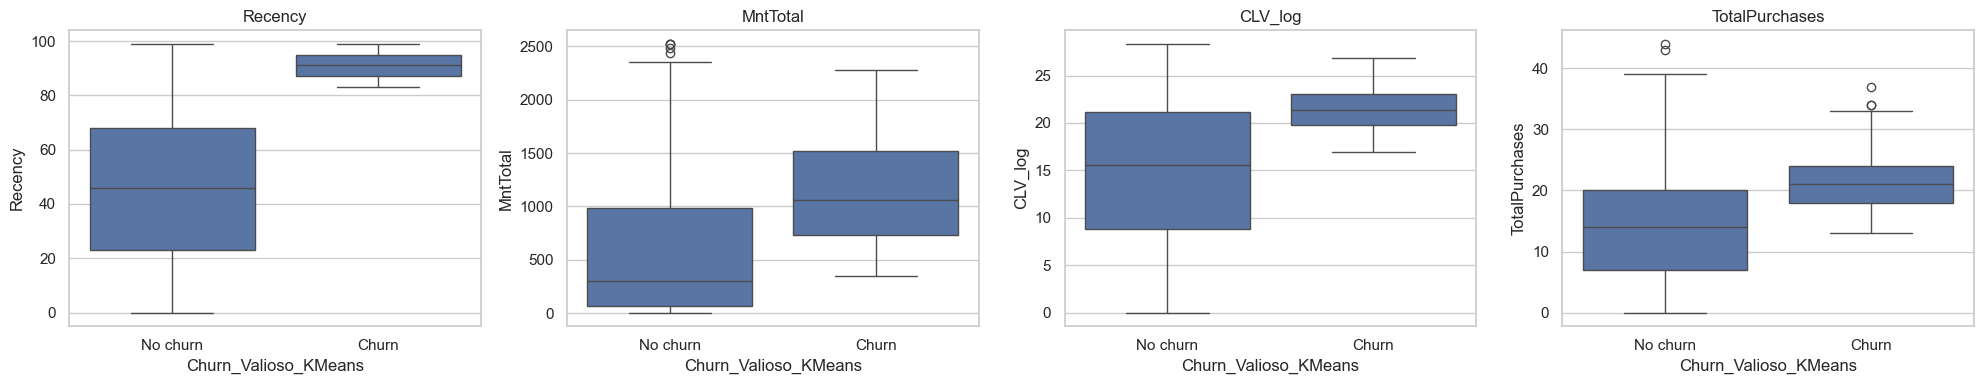

In [5]:
top_vars = res_num.nsmallest(4, "p_value")["Variable"].tolist()
print("Variables numéricas más relevantes:", top_vars)

fig, axes = plt.subplots(1, len(top_vars), figsize=(5*len(top_vars), 4))
if len(top_vars) == 1:
    axes = [axes]

for ax, var in zip(axes, top_vars):
    sns.boxplot(x="Churn_Valioso_KMeans", y=var, data=df, ax=ax)
    ax.set_xticklabels(["No churn", "Churn"], rotation=0)
    ax.set_title(var)

plt.tight_layout()
plt.show()

## 4. CDA categórico — Chi-cuadrado y V de Cramer

Analizamos ahora si existe relación entre el **Churn Valioso K-Means** y variables
categóricas como:

- `Education`
- `Marital_Status`
- `Kidhome`
- `Teenhome`
- `Response`
- `Complain` (si están presentes)

Usamos:

- **Chi-cuadrado** para independencia,
- **V de Cramer** para la magnitud de la asociación.

In [6]:
def cramers_v(tabla):
    chi2, _, _, _ = chi2_contingency(tabla)
    n = tabla.sum().sum()
    r, k = tabla.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

vars_cat = ["Education", "Marital_Status", "Kidhome", "Teenhome", "Response", "Complain"]
resultados_cat = []

for var in vars_cat:
    if var not in df.columns:
        continue

    tabla = pd.crosstab(df[var], df["Churn_Valioso_KMeans"])
    if tabla.shape[1] < 2:
        continue

    chi2, p_value, dof, _ = chi2_contingency(tabla)
    v = cramers_v(tabla)

    resultados_cat.append({
        "Variable": var,
        "chi2": chi2,
        "p_value": p_value,
        "V_de_Cramer": v,
        "dof": dof
    })

res_cat = pd.DataFrame(resultados_cat).sort_values("p_value")
res_cat

,Variable,chi2,p_value,V_de_Cramer,dof
2,Kidhome,85.388765,2.871212e-19,0.195243,2
3,Teenhome,12.161275,2.286718e-03,0.073683,2
0,Education,7.366403,1.177467e-01,0.057346,4
1,Marital_Status,3.566167,8.281683e-01,0.039900,7


### 4.1. Distribución de churn por variables categóricas relevantes

Variables categóricas más relevantes: ['Kidhome', 'Teenhome']


<Figure size 600x400 with 0 Axes>

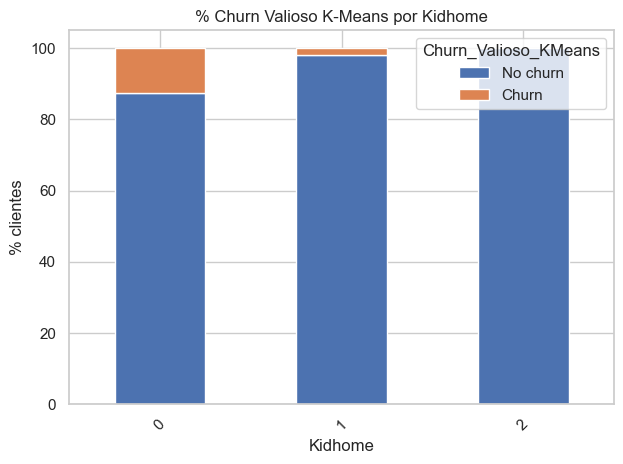

<Figure size 600x400 with 0 Axes>

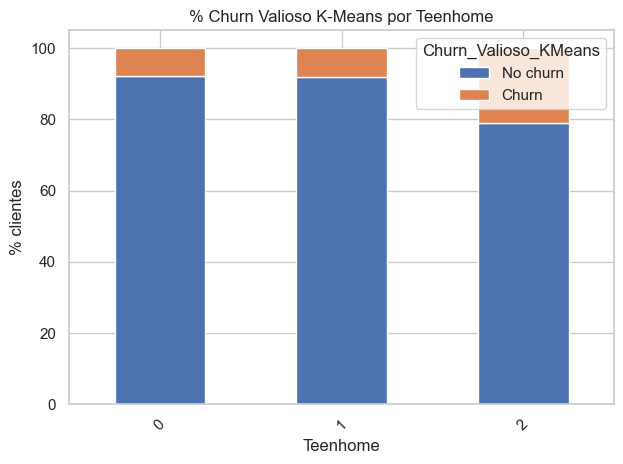

In [7]:
top_cat = res_cat.nsmallest(2, "p_value")["Variable"].tolist()
print("Variables categóricas más relevantes:", top_cat)

for var in top_cat:
    plt.figure(figsize=(6,4))
    tabla = pd.crosstab(df[var], df["Churn_Valioso_KMeans"], normalize="index") * 100
    tabla.plot(kind="bar", stacked=True)
    plt.title(f"% Churn Valioso K-Means por {var}")
    plt.ylabel("% clientes")
    plt.legend(["No churn", "Churn"], title="Churn_Valioso_KMeans")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 5. Comparación entre definiciones de churn

Comparamos el comportamiento del **Churn Valioso K-Means** frente al
**Churn K-Means simple** (solo recency) para ver si realmente estamos capturando
pérdida de valor y no solo inactividad.

In [8]:
comparacion = []

for col, name in [
    ("Churn_Valioso_KMeans", "Churn Valioso K-Means"),
    ("Churn_KMeans", "Churn K-Means simple")
]:
    tasa = df[col].mean()
    clv_churn = df.loc[df[col] == 1, "CLV_log"].mean()
    clv_no_churn = df.loc[df[col] == 0, "CLV_log"].mean()

    comparacion.append({
        "Definicion": name,
        "tasa_churn": tasa,
        "CLV_promedio_churn": clv_churn,
        "CLV_promedio_no_churn": clv_no_churn
    })

pd.DataFrame(comparacion)

,Definicion,tasa_churn,CLV_promedio_churn,CLV_promedio_no_churn
0,Churn Valioso K-Means,0.081250,21.444268,14.973383
1,Churn K-Means simple,0.165179,15.704599,15.458490


## 6. Conclusiones del CDA — Churn Valioso K-Means

El análisis confirma que la definición de **Churn Valioso K-Means** (inactividad ≥ 83 días + CLV alto)
es robusta y captura abandono realmente relevante para el negocio.

Las pruebas numéricas muestran diferencias muy fuertes entre churners y no churners en variables clave
como **Recency**, **MntTotal**, **TotalPurchases**, **Income**, **Perc_CatalogPurchases** y
**NumWebVisitsMonth**. Esto indica que los clientes valiosos que abandonan tienen patrones claros de
gasto y comportamiento antes de irse.

En las variables categóricas, **Kidhome** y **Teenhome** muestran asociaciones significativas, lo que
añade un componente demográfico útil. Education y Marital_Status tienen un impacto menor.

Al comparar definiciones, el churn K-Means simple detecta solo inactividad, pero **no distingue valor**.
En cambio, el **Churn Valioso K-Means** sí separa a los clientes con CLV claramente superior, por lo que
es la etiqueta adecuada para predecir abandono valioso.

Con estos resultados, tenemos justificación estadística suficiente para pasar al modelado: sabemos qué
variables aportan señal y contamos con una etiqueta estable y modelable para el modelo supervisado de
churn valioso.

## 7. Selección de variables para el modelo (resumen)

A partir del CDA, podemos decidir qué variables tienen sentido para el modelo supervisado de churn valioso:

- **Variables fuertes (candidatas a entrar en el modelo):**
  - Numéricas con diferencias claras: `Recency`, `MntTotal`, `TotalPurchases`, `Income`,
    `Perc_CatalogPurchases`, `NumWebVisitsMonth`.
  - Categóricas con asociación significativa: `Kidhome`, `Teenhome`.

- **Variables débiles o poco informativas:**
  - Variables sin diferencias claras entre churn y no churn (por ejemplo `Perc_WebPurchases`
    o algunas demográficas con p_value alto). Estas pueden eliminarse para reducir ruido.

- **Variables que no deben usarse por fuga de información (*leakage*):**
  - `CLV_log`, porque forma parte directa de la definición del *Churn Valioso*.
    Recency sí puede utilizarse, ya que es un estado observable del cliente y cualquier
    modelo de negocio real puede usarlo como predictor.

Con esta selección, el dataset queda más limpio, interpretable y preparado para el siguiente paso:
el notebook de modelado (`4_Modelo_Churn_Valioso.ipynb`), donde se probarán distintos algoritmos
supervisados utilizando estas variables como entrada.